## Code Modules & Functions

In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,tensorflow as tf
import h5py,imageio,os,torch
import seaborn as sn,pylab as pl
from tensorflow.keras.preprocessing import image as tkimg
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from skimage import io; from tqdm import tqdm
from ipywidgets import widgets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils
dev=torch.device('cuda:0' \
if torch.cuda.is_available() else 'cpu')
from IPython.core.magic import register_line_magic
from IPython.display import Image
file_path='../input/tomato-cultivars/'

In [2]:
def paths2tensor(img_paths,file_path,img_size):
    tensor=[]
    for img_path in tqdm(img_paths):
        img0=tkimg.load_img(
            file_path+img_path,
            target_size=(img_size,img_size))
        img=tkimg.img_to_array(img0)
        tensor.append(np.expand_dims(img,axis=0))
    return np.vstack(tensor)
def animate(images):
    converted_images=np.clip(images*255,0,255).astype(np.uint8)
    imageio.mimsave('animation.gif',converted_images)
    return Image(open('animation.gif','rb').read())
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1)
    v2norm=tf.norm(v2)
    v2normalized=v2*(v1norm/v2norm)
    vectors=[]
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-1)
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=\
        interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)
def plcmap(cmap,n):
    return [pl.cm.get_cmap(cmap)(i/n)[:3] 
            for i in range(1,n+1)]
plcmap('Reds',5)

[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),
 (0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
 (0.9466666666666667, 0.26823529411764707, 0.19607843137254902),
 (0.7364705882352941, 0.08, 0.10117647058823528),
 (0.403921568627451, 0.0, 0.05098039215686274)]

## Data Processing

In [3]:
names=['Kumato','Beefsteak','Tigerella',
       'Roma','Japanese Black Trifele',
       'Yellow Pear','Sun Gold','Green Zebra',
       'Cherokee Purple','Oxheart','Blue Berries',
       'San Marzano','Banana Legs',
       'German Orange Strawberry','Supersweet 100']
file_list=sorted(os.listdir(file_path))
img_size=160
labels=np.array([int(el[:2]) for el in file_list],
                dtype=np.int8)-1
images=np.array(paths2tensor(
    file_list,file_path=file_path,img_size=img_size),
    dtype=np.float32)/255
N=labels.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_train=images[:n],images[n:]
y_test,y_train=labels[:n],labels[n:]

100%|██████████| 776/776 [00:07<00:00, 109.22it/s]


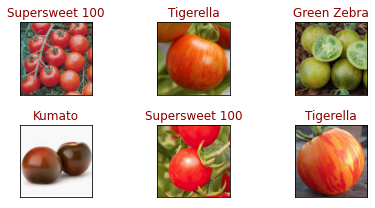

train                test
0  (621, 160, 160, 3)  (155, 160, 160, 3)
1             float32             float32
2              (621,)              (155,)
3                int8                int8

In [4]:
df=pd.DataFrame([[x_train.shape,x_test.shape],
                 [x_train.dtype,x_test.dtype],
                 [y_train.shape,y_test.shape],
                 [y_train.dtype,y_test.dtype]],               
                columns=['train','test'])
start=100
def display_imgs(images,labels,names,start):
    fig=pl.figure(figsize=(6,3))
    n=np.random.randint(0,start-1)
    for i in range(n,n+6):
        ax=fig.add_subplot(2,3,i-n+1,xticks=[],yticks=[])
        ax.set_title(
            names[labels[i]],color='darkred',fontsize=12)
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(images,labels,names,start); display(df)

In [5]:
with h5py.File('TomatoCultivarImages.h5','w') as f:
    f.create_dataset('train_images',data=x_train)
    f.create_dataset('train_labels',data=y_train)
    f.create_dataset('test_images',data=x_test)
    f.create_dataset('test_labels',data=y_test)
os.stat('TomatoCultivarImages.h5')

os.stat_result(st_mode=33188, st_ino=262155, st_dev=1793, st_nlink=1, st_uid=0, st_gid=0, st_size=238392072, st_atime=1612216367, st_mtime=1612216367, st_ctime=1612216367)

In [6]:
x_valid,y_valid=x_test[:int(n/2)],y_test[:int(n/2)]
x_test,y_test=x_test[int(n/2):],y_test[int(n/2):]

In [7]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
batch_size2=int(8); img_size2=int(64)
n_train=batch_size2*(x_train.shape[0]//batch_size2)
x_train2=np.transpose(x_train,(0,3,1,2))[:n_train]
print(x_train2.mean(),x_train2.std())
n_valid=batch_size2*(x_valid.shape[0]//batch_size2)
x_valid2=np.transpose(x_valid,(0,3,1,2))[:n_valid]
n_test=batch_size2*(x_test.shape[0]//batch_size2)
x_test2=np.transpose(x_test,(0,3,1,2))[:n_test]
random_seed=23
train2=TData(x_train2,y_train[:n_train])
valid2=TData(x_valid2,y_valid[:n_valid])
test2=TData(x_test2,y_test[:n_test])
dataloaders={'train':tdl(dataset=train2,shuffle=True,batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True,batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True,batch_size=batch_size2)}
del train2,valid2,test2

0.43813926 0.29305395


Image dimensions: torch.Size([8, 3, 160, 160])
Label dimensions: torch.Size([8])


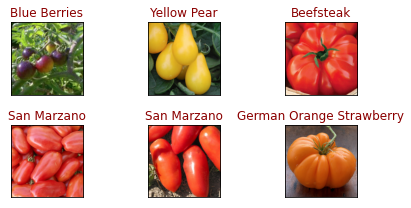

In [8]:
@register_line_magic
def display_data_imgs(data):
    global names
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        images=[np.transpose(images[i],(1,2,0)) 
                for i in range(len(images))]
        display_imgs(images,labels,names,2)
        break
%display_data_imgs valid

## Data Representation

In [9]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

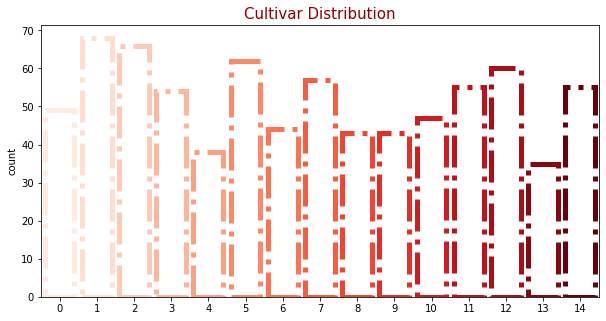

In [10]:
pl.figure(figsize=(10,5))
sn.countplot(x=labels,facecolor=(0,0,0,0),
             linewidth=5,linestyle='-.',
             edgecolor=plcmap('Reds',15))
pl.title('Cultivar Distribution',
         color='darkred',fontsize=15);

label:  2 Tigerella


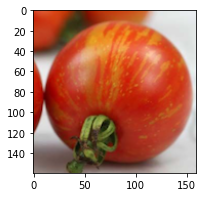

In [11]:
n=np.random.randint(50)
print('label: ',y_test[n],names[y_test[n]])
pl.figure(figsize=(3,3))
pl.imshow((x_test[n]));

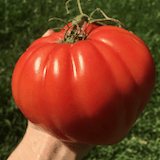

In [12]:
imgs=np.vstack([interpolate_hypersphere(x_test[0],x_test[1],120),
                interpolate_hypersphere(x_test[1],x_test[0],120)])
animate(imgs)